In [42]:
# Imports
from pathlib import Path
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.formula.api as sm
import pymannkendall as mk

import warnings

path_to_data_raw = Path("../src/data/raw")
path_to_data_processed = Path("../src/data/processed")

In [43]:
# Set path to data, check that all files needed are there
datafiles = list(path_to_data_raw.glob("*"))
datafiles_names = [file.name for file in datafiles]
datafiles_required = [
    "ET_year_month.xlsx",
    "PTQ_year_month.xlsx",
    "Reference_PQ_year_month.xlsx"
]
for file in datafiles_required:
    if file not in datafiles_names:
        raise FileNotFoundError(f"Missing file: {file}")

In [44]:
# Load the data
ET_year_month = pd.read_excel(path_to_data_raw / "ET_year_month.xlsx")
PTQ_year_month = pd.read_excel(path_to_data_raw / "PTQ_year_month.xlsx")
Reference_PQ_year_month = pd.read_excel(path_to_data_raw / "Reference_PQ_year_month.xlsx")
datasets = {"ET_year_month": ET_year_month, "PTQ_year_month": PTQ_year_month, "Reference_PQ_year_month": Reference_PQ_year_month}


name_mapping = {
    "Unnamed: 0": "date",
    "Year": "year",
    "Month": "month",
    "Potential evapotranspiration [mm/month]": "potential_evapotranspiration",
    "Precipitation (mm/day)": "precipitation",
    "Discharge (m3/s)": "discharge",
    "Temperature 0C": "temperature",
    "Reference precipitation [mm/day]": "precipitation_reference",
    "Reference discharge (m3/s)": "discharge_reference"
}
for name, dataset in datasets.items():
    dataset.rename(name_mapping,axis=1, inplace=True)
    dataset["date"] = pd.to_datetime(dataset["date"], dayfirst=True)

    mismatch_year = dataset["date"].dt.year != dataset["year"]
    mismatch_month = dataset["date"].dt.month != dataset["month"]
    mismatch = np.logical_or(mismatch_year, mismatch_month)
    mismatch_dict = {
        date: f"(year={year}, month={month})"
        for date, year, month in zip(
            dataset["date"][mismatch].astype(str),
            dataset["year"][mismatch].astype(str),
            dataset["month"][mismatch].astype(str)
        )
    }
    if np.any(mismatch):
        warnings.warn(
            f"""
            Detected mismatch in {name} between month/year columns and date columns for the following dates:
            {str(mismatch_dict)}
            Date column will be used, while year/month columns are dropped.
            """
        )
    dataset["year"] = dataset["date"].dt.year
    dataset["month"] = dataset["date"].dt.month


C:\Users\MUNRAS\AppData\Local\Temp\ipykernel_14760\1954060784.py:35: UserWarning: 
            Detected mismatch in Reference_PQ_year_month between month/year columns and date columns for the following dates:
            {'1900-01-01': '(year=1899, month=12)', '1900-02-01': '(year=1900, month=1)'}
            Date column will be used, while year/month columns are dropped.
            
  warnings.warn(


In [45]:
# Calculate yearly summaries for precipitation and temperature
timeseries = PTQ_year_month.merge(
    Reference_PQ_year_month[["date", "precipitation_reference", "discharge_reference"]], on="date", how="outer"
)
timeseries.sort_values("date", inplace=True)
nans_per_col = np.isnan(timeseries).sum(axis=0)
print(f"NaN's per column:\n", str(nans_per_col))

annual = timeseries.groupby(timeseries["date"].dt.year).agg(
    {"precipitation": "sum", "discharge": "sum", "precipitation_reference": "sum", "discharge_reference": "sum"}
)

# Sort by year descending, calculate cumulative sums
annual.sort_index(inplace=True, ascending=False)
for col in annual.columns:
    annual[f"cumsum_{col}"] = np.cumsum(annual[col])

NaN's per column:
 date                           0
year                           0
month                          0
precipitation                  0
discharge                  17797
temperature                    0
precipitation_reference        0
discharge_reference        17797
dtype: int64


In [46]:
annual

,precipitation,discharge,precipitation_reference,discharge_reference,cumsum_precipitation,cumsum_discharge,cumsum_precipitation_reference,cumsum_discharge_reference
date,,,,,,,,
2007,1044.8100,7087.9573,992.62,6379.16157,1044.8100,7087.9573,992.62,6379.16157
2006,1149.9300,5708.0259,1092.55,5137.22331,2194.7400,12795.9832,2085.17,11516.38488
2005,893.3400,5345.5330,848.72,4810.97970,3088.0800,18141.5162,2933.89,16327.36458
2004,1131.4100,5791.0881,1074.87,5211.97929,4219.4900,23932.6043,4008.76,21539.34387
2003,844.5000,4554.1893,802.33,4098.77037,5063.9900,28486.7936,4811.09,25638.11424
...,...,...,...,...,...,...,...,...
1879,698.1600,0.0000,884.48,0.00000,103863.7075,565517.1888,116004.56,414203.76072
1878,651.5025,0.0000,825.31,0.00000,104515.2100,565517.1888,116829.87,414203.76072
1877,780.8925,0.0000,989.27,0.00000,105296.1025,565517.1888,117819.14,414203.76072


C:\Users\MUNRAS\AppData\Local\Temp\ipykernel_14760\468686893.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


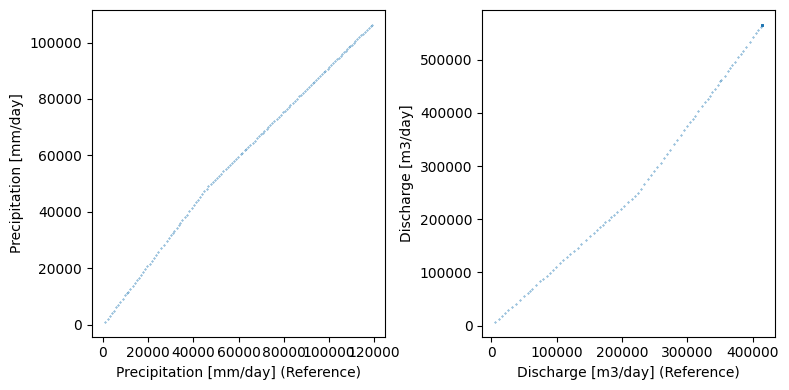

In [47]:
# The plots that are being asked for
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
# Precipitation
axs[0].scatter(annual["cumsum_precipitation_reference"], annual["cumsum_precipitation"], s=0.1)
axs[0].set_xlabel("Precipitation [mm/day] (Reference)")
axs[0].set_ylabel("Precipitation [mm/day]")

# Discharge
axs[1].scatter(annual["cumsum_discharge_reference"], annual["cumsum_discharge"], s=0.1)
axs[1].set_xlabel("Discharge [m3/day] (Reference)")
axs[1].set_ylabel("Discharge [m3/day]")

fig.tight_layout()
fig.show()

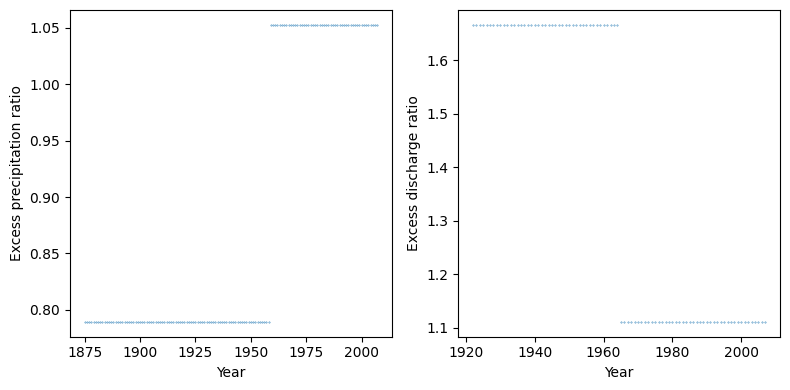

In [48]:
# Plots that are actually useful for determining when the changepoint occurs
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
# Precipitation
axs[0].scatter(annual.index, annual["precipitation"] / annual["precipitation_reference"], s=0.1)
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Excess precipitation ratio")

# Discharge
axs[1].scatter(annual.index, annual["discharge"] / annual["discharge_reference"], s=0.1)
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Excess discharge ratio")

fig.tight_layout()
plt.show()

In [49]:
# An argmax of the absolute difference should extract the changepoints nicely
# Note that subsequent iloc can use the index directly
breakpoint_index_precipitation = np.argmax(np.abs(np.diff(annual["precipitation"] / annual["precipitation_reference"])))
breakpoint_index_discharge = np.nanargmax(np.abs(np.diff(annual["discharge"] / annual["discharge_reference"])))
breakpoint_year_precipitation = annual.index[breakpoint_index_precipitation]
breakpoint_year_discharge = annual.index[breakpoint_index_discharge]
print(f"Breakpoints in years {breakpoint_year_precipitation} and {breakpoint_year_discharge} for precipitation and discharge respectively.")
# Looks pretty similar to the plots above
# Note the use of np.nanargmax, because discharge is 0/0 for some of the older records

Breakpoints in years 1959 and 1965 for precipitation and discharge respectively.


In [50]:
# We should calculate correction_factor = slope_after_break / slope_before_break
# Slopes should be estimated via linear regression / OLS
annual_after_precip_breakpoint = annual.iloc[:breakpoint_index_precipitation].copy()
annual_after_discharge_breakpoint = annual.iloc[:breakpoint_index_discharge].copy()
annual_before_precip_breakpoint = annual.iloc[breakpoint_index_precipitation:].copy()
annual_before_discharge_breakpoint = annual.iloc[breakpoint_index_discharge:].copy()

# Run regressions
slope_after_precipitation = sm.ols(formula="cumsum_precipitation ~ 1 + cumsum_precipitation_reference", data=annual_after_precip_breakpoint).fit().params.loc["cumsum_precipitation_reference"]
slope_before_precipitation = sm.ols(formula="cumsum_precipitation ~ 1 + cumsum_precipitation_reference", data=annual_before_precip_breakpoint).fit().params.loc["cumsum_precipitation_reference"]
slope_after_discharge = sm.ols(formula="cumsum_discharge ~ 1 + cumsum_discharge_reference", data=annual_after_discharge_breakpoint).fit().params.loc["cumsum_discharge_reference"]
slope_before_discharge = sm.ols(formula="cumsum_discharge ~ 1 + cumsum_discharge_reference", data=annual_before_discharge_breakpoint).fit().params.loc["cumsum_discharge_reference"]
print(f"Slopes: {round(float(slope_after_precipitation),3), round(float(slope_before_precipitation),3), round(float(slope_after_discharge),3), round(float(slope_before_discharge),3)}")

# Calculate correction factors
cf_precipitation = slope_after_precipitation / slope_before_precipitation
cf_discharge = slope_after_discharge / slope_before_discharge
print(f"Correction factors: {round(float(cf_precipitation),3), round(float(cf_discharge),3)}")

# Calculate correction factors based on group means (because I want to see how similar the results are)
# these are easy to interpret as the level change per year
# clearly, they are close to the above, but I'm pretty sure they are different in general and thus I don't know how to interpret the prescribed correction factors.
beta_after_precipitation = annual_after_precip_breakpoint["precipitation"].mean() / annual_after_precip_breakpoint["precipitation_reference"].mean()
beta_before_precipitation = annual_before_precip_breakpoint["precipitation"].mean() / annual_before_precip_breakpoint["precipitation_reference"].mean()
beta_after_discharge = annual_after_discharge_breakpoint["discharge"].mean() / annual_after_discharge_breakpoint["discharge_reference"].mean()
beta_before_discharge = annual_before_discharge_breakpoint["discharge"].mean() / annual_before_discharge_breakpoint["discharge_reference"].mean()
print(f"Custom 'slopes': {tuple((float(round(x,3)) for x in [beta_after_precipitation, beta_before_precipitation, beta_after_discharge, beta_before_discharge]))}")
print(f"Custom 'cf's': {tuple((float(round(x,3)) for x in [beta_after_precipitation / beta_before_precipitation, beta_after_discharge / beta_before_discharge]))}")

Slopes: (1.053, 0.789, 1.111, 1.667)
Correction factors: (1.333, 0.667)
Custom 'slopes': (1.053, 0.792, 1.111, 1.653)
Custom 'cf's': (1.328, 0.672)


In [51]:
timeseries

,date,year,month,precipitation,discharge,temperature,precipitation_reference,discharge_reference
0,1875-01-01,1875,1,2.0100,NaN,-3.1,2.55,NaN
1,1875-01-02,1875,1,0.0825,NaN,-3.3,0.10,NaN
2,1875-01-03,1875,1,0.1575,NaN,-2.2,0.20,NaN
3,1875-01-04,1875,1,0.8625,NaN,1.1,1.09,NaN
4,1875-01-05,1875,1,6.2925,NaN,1.3,7.97,NaN
...,...,...,...,...,...,...,...,...
48572,2007-12-27,2007,12,0.2000,NaN,6.4,0.19,NaN
48573,2007-12-28,2007,12,9.0400,NaN,6.6,8.59,NaN
48574,2007-12-29,2007,12,9.1900,NaN,6.4,8.73,NaN
48575,2007-12-30,2007,12,14.3200,NaN,5.3,13.60,NaN


In [17]:
# Calculate homogenized timeseries
timeseries_corrected = timeseries.copy()
timeseries_corrected["precipitation"] = timeseries["precipitation"] * np.where(timeseries["date"].dt.year<breakpoint_year_precipitation, cf_precipitation, 1)
timeseries_corrected["discharge"] = timeseries["discharge"] * np.where(timeseries["date"].dt.year<breakpoint_year_discharge, cf_discharge, 1)
timeseries_corrected.to_csv(path_to_data_processed / "timeseries_corrected.csv", index=False)

In [18]:
# Calculate monthly statistics
monthly_statistics = timeseries_corrected.groupby(["year", "month"]).agg({
    "precipitation": ["max", "min", "sum"],
    "discharge": ["max", "min", "mean"],
    "temperature": ["max", "min", "mean"]
})
monthly_statistics.columns = ['_'.join(col).strip() for col in monthly_statistics.columns.values]
monthly_statistics.reset_index(inplace=True)

# Attach evapotranspiration
monthly_statistics = monthly_statistics.merge(ET_year_month, on=["year", "month"], how="outer")
monthly_statistics.drop(["year", "month"], axis=1, inplace=True)

In [19]:
# Calculate yearly statistics
annual_statistics = timeseries_corrected.groupby("year").agg({
    "precipitation": ["max", "min", "sum"],
    "discharge": ["max", "min", "mean"],
    "temperature": ["max", "min", "mean"]
})
annual_statistics.columns = ['_'.join(col).strip() for col in annual_statistics.columns.values]

# Calculate yearly evapotranspiration statistics
annual_et = ET_year_month.groupby("year").agg({
    "potential_evapotranspiration": ["max", "min", "sum"]
})
annual_et.columns = ['_'.join(col).strip() for col in annual_et.columns.values]
annual_et.reset_index(inplace=True)

# Attach evapotranspiration
annual_statistics = annual_statistics.merge(annual_et, on="year", how="outer")

# Produce a reasonable date-index
annual_statistics["date"] = pd.to_datetime(dict(year=annual_statistics["year"], month=1, day=1))
annual_statistics.drop(["year"], axis=1, inplace=True)

In [20]:
annual_statistics.to_csv(path_to_data_processed / "annual_statistics.csv", index=False)
monthly_statistics.to_csv(path_to_data_processed / "monthly_statistics.csv", index=False)

## Trend Estimation

In [21]:
def trend_analysis(timeseries: pd.DataFrame, plot: bool = True) -> pd.DataFrame:
    tests = {}
    for col in timeseries.columns:
        tests[col] = mk.original_test(timeseries[col])

    results = {
        "column": timeseries.columns,
        "intercept": [tests[col].intercept for col in timeseries.columns],
        "slope": [tests[col].slope for col in timeseries.columns],
        "p": [tests[col].p for col in timeseries.columns],
        "range": len(timeseries.index) # Does not work for non-uniform spacing, but it's easy
    }

    if plot:
        figshape = int(np.ceil(np.sqrt(len(timeseries.columns))))
        fig, axs = plt.subplots(
            ncols=figshape, nrows=figshape,
            figsize=(4*figshape, 4*figshape)
        )
        predictions = {
            col: intercept + slope*np.arange(len(timeseries.index))
            for col,intercept,slope in zip(
                timeseries.columns,
                results["intercept"],
                results["slope"]
            )
        }
        for col, ax in zip(timeseries.columns, axs.flatten()):
            ax.scatter(timeseries.index, timeseries[col], s=0.5)
            ax.plot(timeseries.index, predictions[col], "--", color="red")
            ax.set_ylabel(col)
            ax.set_xlabel(timeseries.index.name)

        for ax in axs.flatten()[len(timeseries.columns):]:
            ax.set_axis_off()
        fig.tight_layout()
        plt.show()

    return pd.DataFrame(results)

In [22]:
annual_statistics = pd.read_csv(path_to_data_processed / "annual_statistics.csv")
annual_statistics["date"] = pd.to_datetime(annual_statistics["date"])
annual_statistics.set_index("date", inplace=True)

monthly_statistics = pd.read_csv(path_to_data_processed / "monthly_statistics.csv")
monthly_statistics["date"] = pd.to_datetime(monthly_statistics["date"])
monthly_statistics.set_index("date", inplace=True)

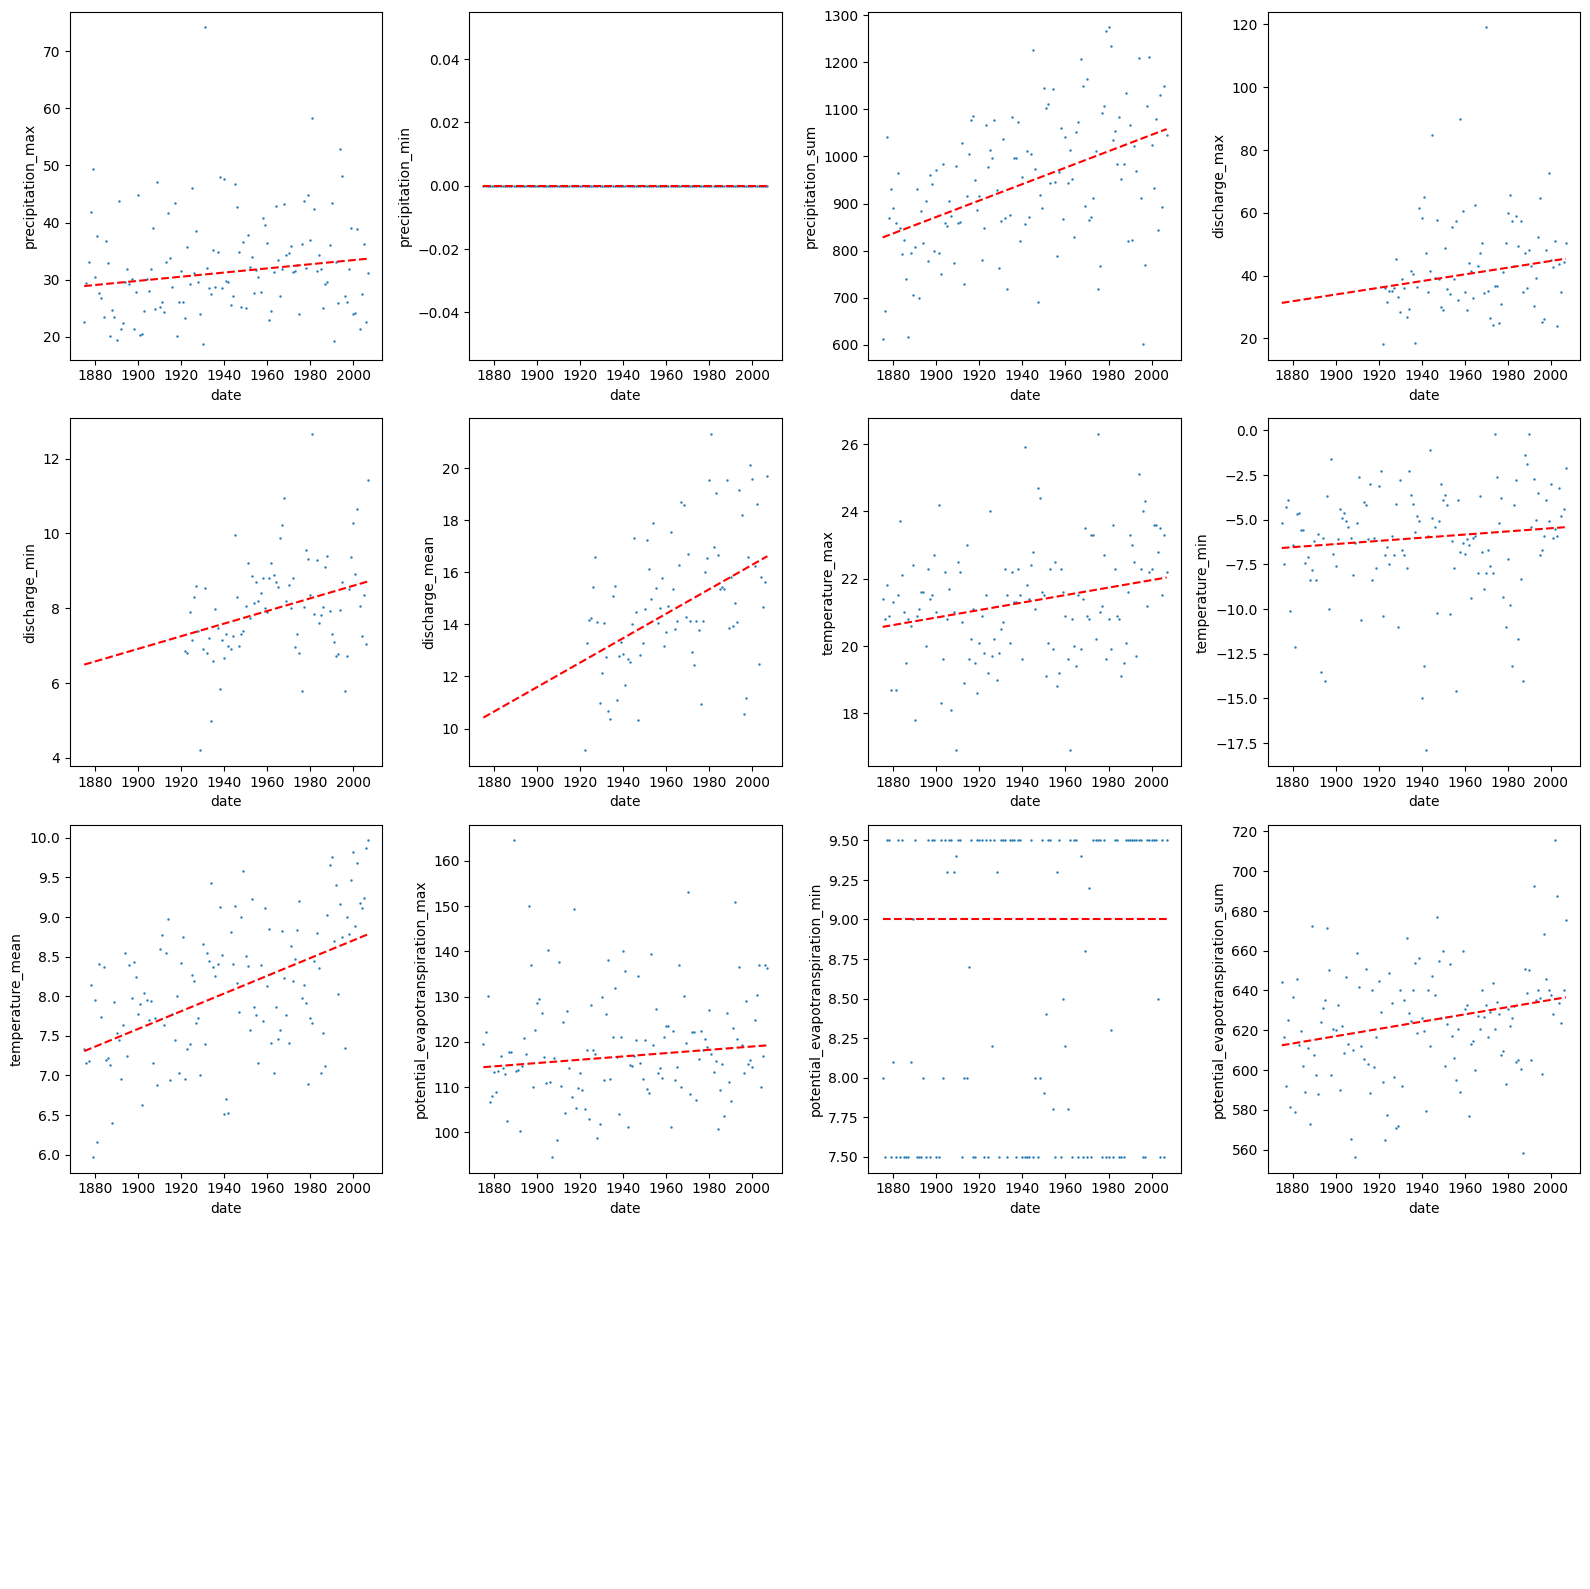

In [23]:
annual_analysis = trend_analysis(annual_statistics)

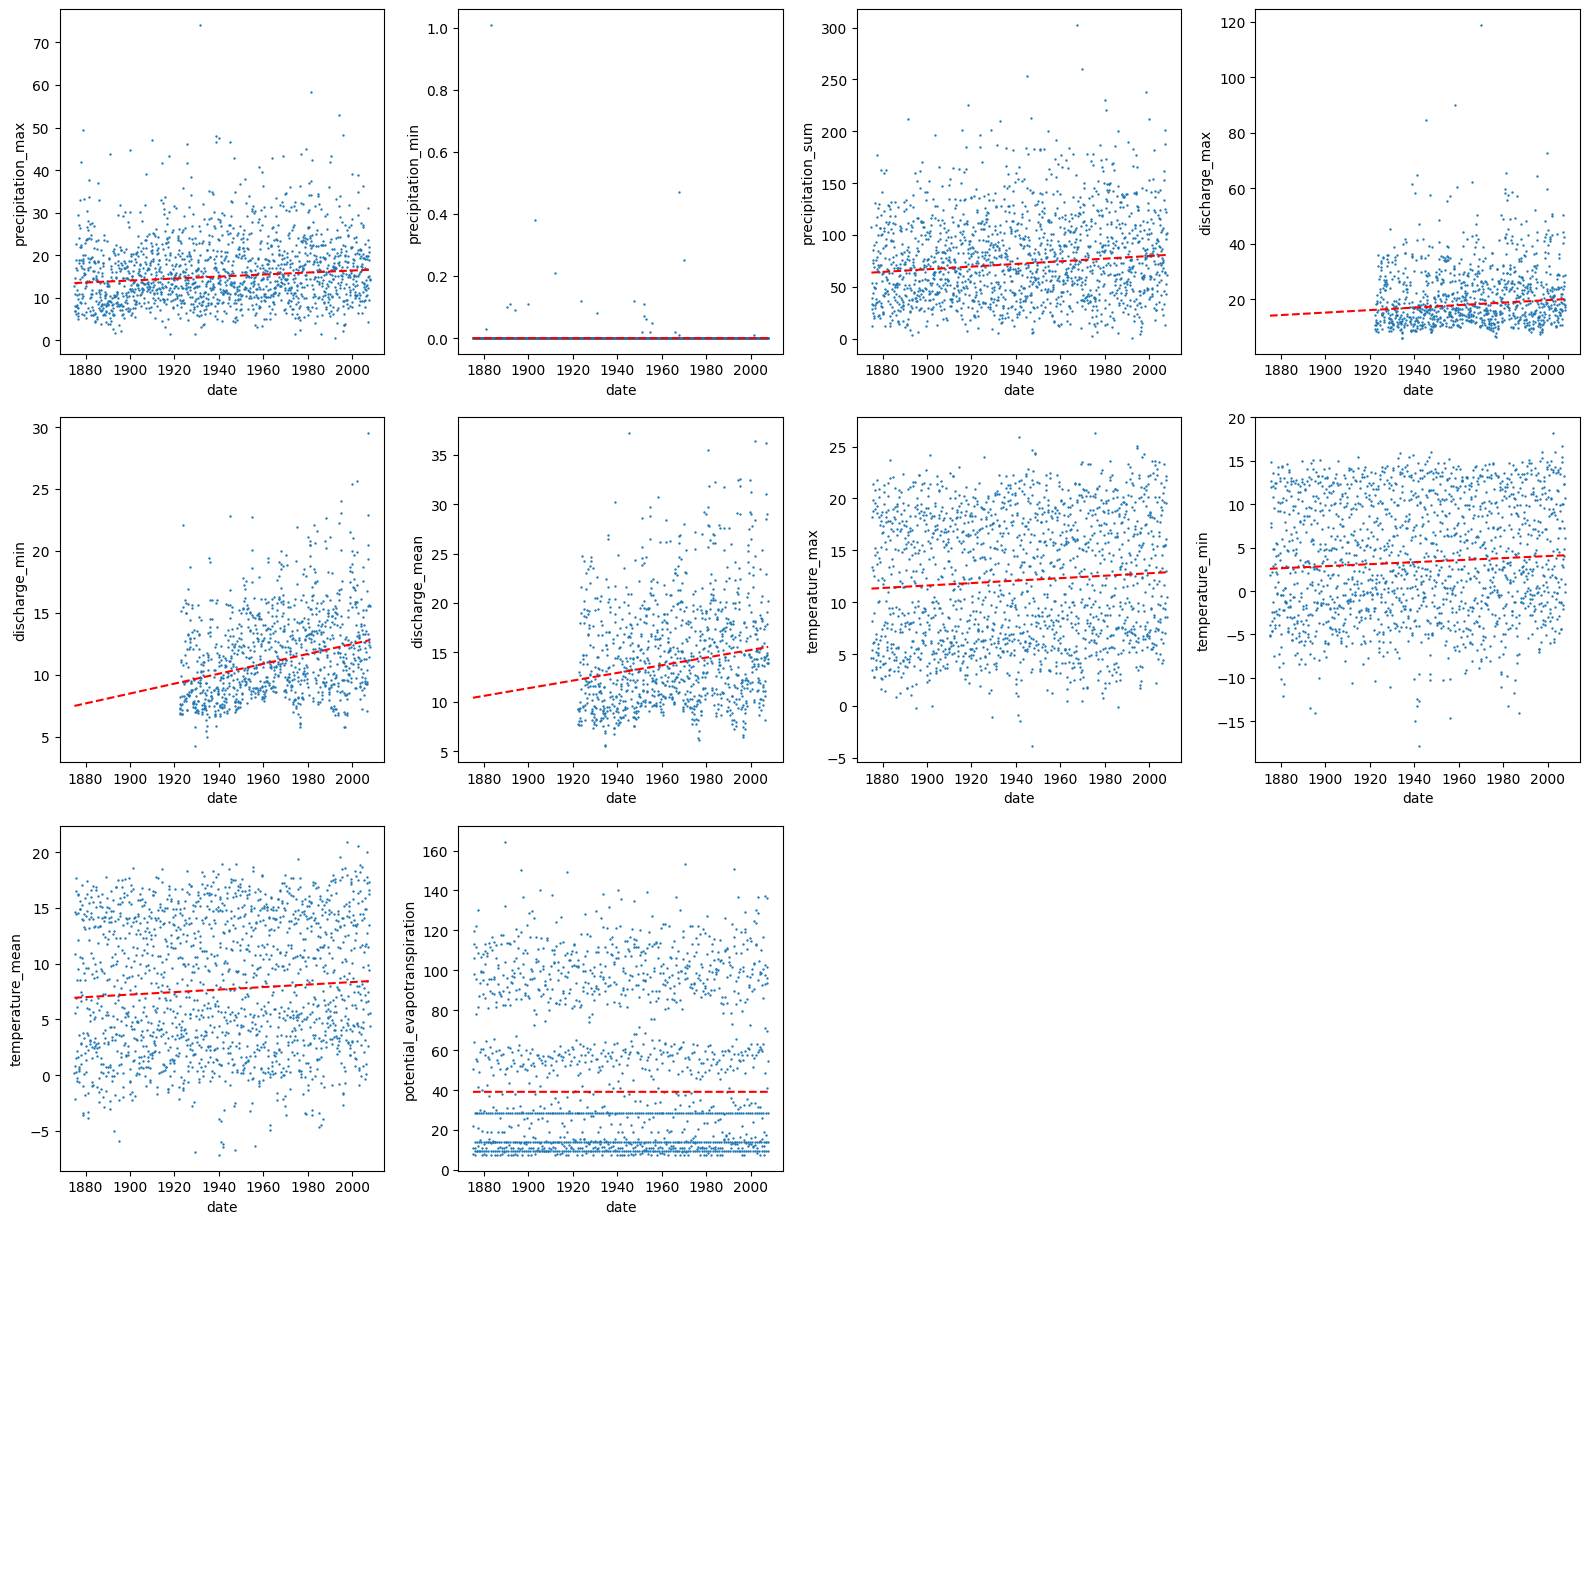

In [24]:
monthly_analysis = trend_analysis(monthly_statistics)

In [25]:
# Do the analysis for each month separately
per_month_analysies = [
    trend_analysis(monthly_statistics[monthly_statistics.index.month==m], plot=False)
    for m in range(1,13)
]
for m in range(len(per_month_analysies)):
    per_month_analysies[m]["month"] = m
per_month_analysies = pd.concat(per_month_analysies, ignore_index=True)

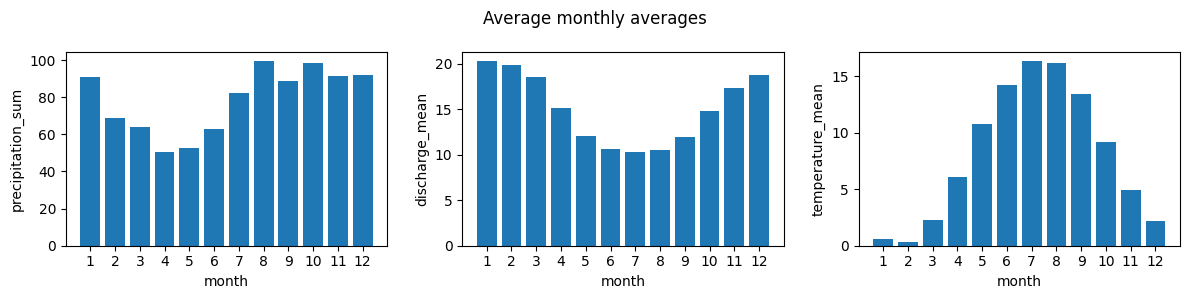

In [26]:
# Plot some per-month statistics
monthly_means = monthly_statistics.groupby(monthly_statistics.index.month).agg("mean")
monthly_means.index.name = "month"
fig, axs = plt.subplots(ncols=3, figsize=(12,3))
for col, ax in zip(["precipitation_sum", "discharge_mean", "temperature_mean"], axs):
    ax.bar(monthly_means.index.astype(str), monthly_means[col])
    ax.set_xlabel(monthly_means.index.name)
    ax.set_ylabel(col)
fig.suptitle("Average monthly averages")
fig.tight_layout()

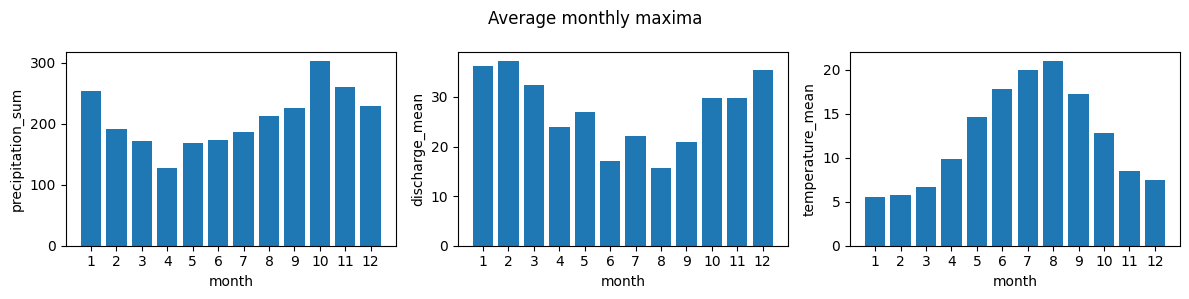

In [27]:
monthly_maxs = monthly_statistics.groupby(monthly_statistics.index.month).agg("max")
monthly_maxs.index.name = "month"
fig, axs = plt.subplots(ncols=3, figsize=(12,3))
for col, ax in zip(["precipitation_sum", "discharge_mean", "temperature_mean"], axs):
    ax.bar(monthly_maxs.index.astype(str), monthly_maxs[col])
    ax.set_xlabel(monthly_maxs.index.name)
    ax.set_ylabel(col)
fig.suptitle("Average monthly maxima")
fig.tight_layout()

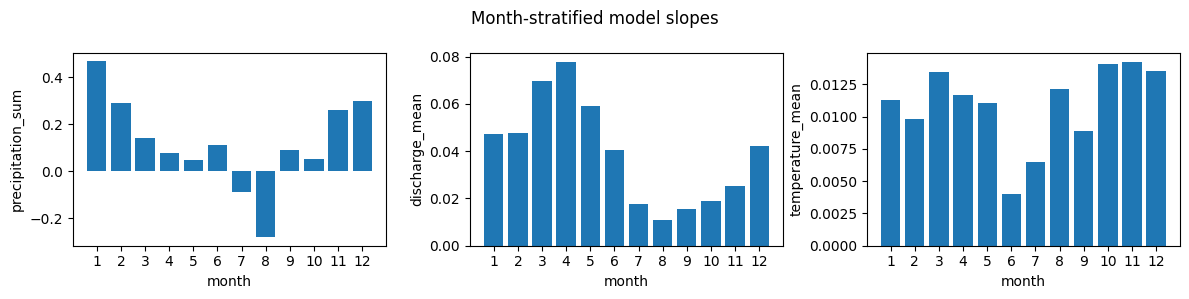

In [28]:
# Monthly slopes bar charts
fig, axs = plt.subplots(ncols=3, figsize=(12,3))
for col, ax in zip(["precipitation_sum", "discharge_mean", "temperature_mean"], axs):
    ax.bar(monthly_maxs.index.astype(str), per_month_analysies[per_month_analysies["column"] == col]["slope"])
    ax.set_xlabel(monthly_maxs.index.name)
    ax.set_ylabel(col)
fig.suptitle("Month-stratified model slopes")
fig.tight_layout()

# Autocorrelation

In [29]:
timeseries_corrected = pd.read_csv(path_to_data_processed / "timeseries_corrected.csv")

In [30]:
acf = {
    col: [timeseries_corrected[col].autocorr(lag=k) for k in range(11)]
    for col in ["precipitation", "temperature", "discharge"]
}

Text(0, 0.5, 'ACF')

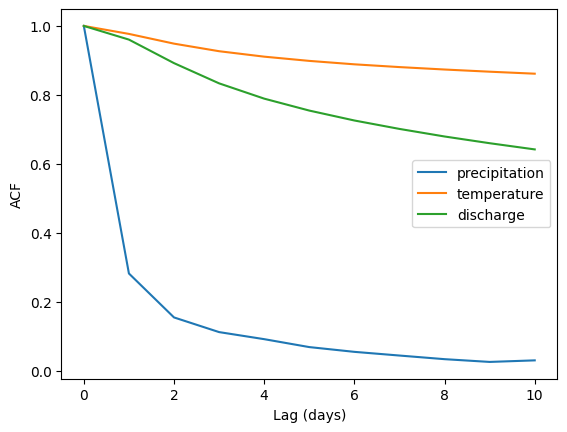

In [31]:
fig, ax = plt.subplots()
for col in acf:
    ax.plot(acf[col], label=col)
ax.legend()
ax.set_xlabel("Lag (days)")
ax.set_ylabel("ACF")

# Flow Duration Curve
It's just the empirical survival function.

In [32]:
timeseries_corrected = pd.read_csv(path_to_data_processed / "timeseries_corrected.csv")

In [33]:
def empirical_cdf(data):
    data_nonan = data[~np.isnan(data)]
    n = len(data_nonan)
    vals, counts = np.unique(data_nonan, return_counts=True)
    cumcounts = np.cumsum(counts)
    cdf = cumcounts / (1+n)
    return vals, cdf

In [34]:
xx, cdf = empirical_cdf(timeseries_corrected["discharge"])
sf = 1-cdf

Text(0, 0.5, 'Discharge (m3/s)')

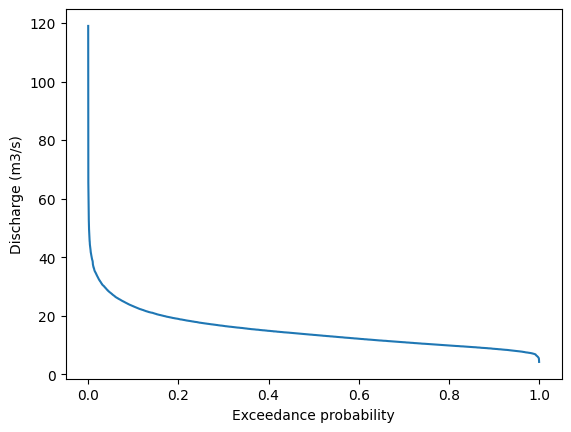

In [35]:
fig, ax = plt.subplots()
ax.plot(sf, xx)
ax.set_xlabel("Exceedance probability")
ax.set_ylabel("Discharge (m3/s)")

# Annual Extrema Analysis
We are supposed to calculate the distribution for the annual minima and maxima for discharge and temperature.

In [36]:
annual_statistics = pd.read_csv(path_to_data_processed / "annual_statistics.csv")
annual_statistics["date"] = pd.to_datetime(annual_statistics["date"])
annual_statistics.set_index("date", inplace=True)

In [37]:
def extreme_value_analysis_max(series, t: np.ndarray=50):
    """Fir a Gumbel distribution to data, extract t-year event and errors."""
    # Remove missing values
    series = series[~np.isnan(series)]

    # Fit a Gumbel distribution by MLE
    params = scipy.stats.gumbel_r.fit(series)
    mu = scipy.stats.gumbel_r.mean(*params)
    sigma = scipy.stats.gumbel_r.std(*params)

    # Calculate the magnitude of a t-year event
    # The formula below should work, but assumptions in the exercise are not specified, only formula
    # t_year_event = scipy.stats.gumbel_r.isf(1/t, *params)
    t_year_event = mu + 0.78*sigma*(-np.log(-np.log(1-1/t))-0.577)

    # Calculate frequency factor and std of t-year-event estimate
    kt = 0.78*(-np.log(-np.log(1-1/t))-0.577)
    st = sigma / np.sqrt(len(series)) * np.sqrt(1 + 1.14*kt + 1.1*kt**2)

    return t_year_event, st

def extreme_value_analysis_min(series, t: np.ndarray=50):
    """Fit a Gumbel distribution to data, extract t-year event and errors."""
    # Remove missing values
    series = series[~np.isnan(series)]

    # Fit a Gumbel distribution by MLE
    # params = scipy.stats.gumbel_r.fit(series)
    mu = np.mean(series) # scipy.stats.gumbel_r.mean(*params)
    sigma = np.std(series) # scipy.stats.gumbel_r.std(*params)

    # Calculate the magnitude of a t-year event
    # The formula below should work, but assumptions in the exercise are not specified, only formula
    # t_year_event = scipy.stats.gumbel_r.isf(1/t, *params)
    t_year_event = mu + 0.78*sigma*(np.log(-np.log(1-1/t))+0.577)

    # Calculate frequency factor and std of t-year-event estimate
    kt = 0.78*(np.log(-np.log(1-1/t))+0.577)
    st = sigma / np.sqrt(len(series)) * np.sqrt(1 - 1.14*kt + 1.1*kt**2)

    return t_year_event, st
    
def gaussian_qq_dd(mu, sigma):
    """Calculate Gaussian quantiles and corresponding density estimates at these."""
    qq = np.linspace(0.005, 0.995, 199).reshape(-1,1)
    qgaus = scipy.stats.norm.ppf(qq, mu.reshape(1,-1), sigma.reshape(1,-1))
    dgaus = scipy.stats.norm.pdf(qgaus, mu.reshape(1,-1), sigma.reshape(1,-1))
    return qgaus, dgaus

def evt_analysis(maxima = None, minima = None, t: np.ndarray = np.array([50, 100, 200])):

    results = {}

    if minima is not None:
        est_min, err_min = extreme_value_analysis_min(minima, t)
        qgauss_min, dgauss_min = gaussian_qq_dd(est_min, err_min)
        results.update({
            "est_min": est_min,
            "err_min": err_min,
            "qgauss_min": qgauss_min,
            "dgauss_min": dgauss_min
        })

    if maxima is not None:
        est_max, err_max = extreme_value_analysis_max(maxima, t)
        qgauss_max, dgauss_max = gaussian_qq_dd(est_max, err_max)
        results.update({
            "est_max": est_max,
            "err_max": err_max,
            "qgauss_max": qgauss_max,
            "dgauss_max": dgauss_max
        })

    return results



In [38]:
tt = np.array([50, 100, 200])
evt_discharge = evt_analysis(maxima=annual_statistics["discharge_max"], minima=annual_statistics["discharge_min"], t=tt)
evt_precipitation = evt_analysis(annual_statistics["precipitation_max"], t=tt)
evt_temperature = evt_analysis(maxima=annual_statistics["temperature_max"], minima=annual_statistics["temperature_min"], t=tt)

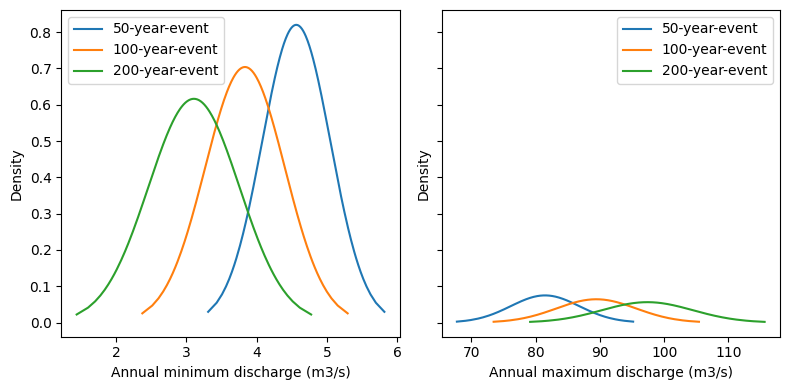

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4), sharey=True)
ax = axs[0]
for i, t in zip(range(evt_discharge["qgauss_min"].shape[-1]), tt):
    ax.plot(evt_discharge["qgauss_min"][:,i], evt_discharge["dgauss_min"][:,i], label=f"{t}-year-event")
ax.set_xlabel("Annual minimum discharge (m3/s)")
ax.set_ylabel("Density")
ax.legend()

ax = axs[1]
for i, t in zip(range(evt_discharge["qgauss_max"].shape[-1]), tt):
    ax.plot(evt_discharge["qgauss_max"][:,i], evt_discharge["dgauss_max"][:,i], label=f"{t}-year-event")
ax.set_xlabel("Annual maximum discharge (m3/s)")
ax.set_ylabel("Density")
ax.legend()

fig.tight_layout()

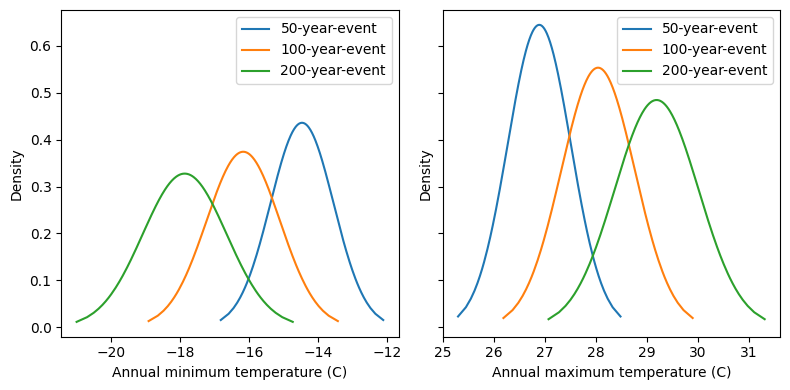

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4), sharey=True)
ax = axs[0]
for i, t in zip(range(evt_temperature["qgauss_min"].shape[-1]), tt):
    ax.plot(evt_temperature["qgauss_min"][:,i], evt_temperature["dgauss_min"][:,i], label=f"{t}-year-event")
ax.set_xlabel("Annual minimum temperature (C)")
ax.set_ylabel("Density")
ax.legend()

ax = axs[1]
for i, t in zip(range(evt_temperature["qgauss_max"].shape[-1]), tt):
    ax.plot(evt_temperature["qgauss_max"][:,i], evt_temperature["dgauss_max"][:,i], label=f"{t}-year-event")
ax.set_xlabel("Annual maximum temperature (C)")
ax.set_ylabel("Density")
ax.legend()

fig.tight_layout()

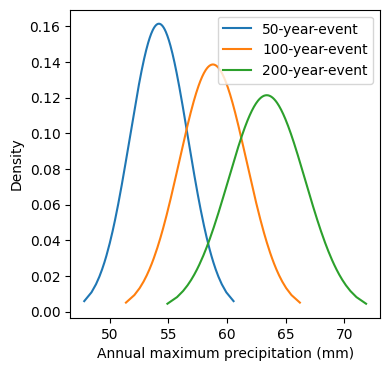

In [41]:
fig, ax = plt.subplots(figsize=(4,4),)
for i, t in zip(range(evt_precipitation["qgauss_max"].shape[-1]), tt):
    ax.plot(evt_precipitation["qgauss_max"][:,i], evt_precipitation["dgauss_max"][:,i], label=f"{t}-year-event")
ax.set_xlabel("Annual maximum precipitation (mm)")
ax.set_ylabel("Density")
ax.legend()